In [151]:
import csv
import keras
import matplotlib.pyplot as plt
import numpy as np

from anytree import Node, RenderTree, Resolver, AnyNode, LevelOrderIter
from tqdm import tqdm_notebook, tqdm

Commandes pour générer les fichiers `.csv` depuis le dump envoyé par la DB :
```
ls | xargs -i basename {} .xlsx | xargs -i ssconvert {}.xlsx {}.csv
find -name '*.csv' | xargs -i wc -l {}
```

In [24]:
FILE_1 = './raw_data/h20162.csv'
FILE_2 = './raw_data/h20172.csv'
EMBEDDING_FILE_PATH = '/home/alexis/mva/word_embeddings/wiki.fr.vec'
ATTRIBUTES = ['tm', 'ms', 'pg', 'a', 'sa']
ATTRIBUTE_ID = ['id_tms', 'id_ms', 'id_pg', 'id_a', 'id_sa']
PADDING = 50

# Load word embeddings

Load FastText pretrained embeddings.

In [3]:
import gensim
from gensim.models import Word2Vec
pretrained_embeddings = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE_PATH, binary=False)

# Load Data

In [152]:
class Line:
    """Parser for rows of input CSV files"""

    def __init__(self, row):
        self.id_tms = row[1]
        self.tm = row[2]
        self.id_ms = row[3]
        self.ms = row[4]
        self.id_pg = row[5]
        self.pg = row[6]
        self.id_a = row[7]
        self.a = row[8]
        # Parse sous-action if exists
        self.id_sa = row[9] if len(row[9]) > 0 else ''
        self.sa = row[10] if len(row[10]) > 0 else ''

In [174]:
def parse_csv(file_path, tree, resolver):
    """Iterates over input CSV file's lines
    to build tree representing data.

    Inputs:
        - path to csv file under study
        - anytree which will be updated
        - anytree resolver for searching in given tree
    """

    with open(file_path, 'r') as input_file:
        reader = csv.reader(input_file, delimiter=',', quotechar='"')

        # Skip header
        next(reader, None)

        # Iterate through rows
        for row in reader:
            # Parse current row
            line = Line(row)

            # Walk in the current tree and potentially
            # build path of the leaf under study.
            current_tree = tree
            current_path = []
            current_id = []

            # Iterate through line attributes, which represent
            # recursive nodes of the leaf under study.
            for attribute, attribute_id in zip(ATTRIBUTES, ATTRIBUTE_ID):
                # Get current node name
                name = getattr(line, attribute)
                if name == '':
                    continue

                # Update id array
                if getattr(line, attribute_id):
                    current_id.append(getattr(line, attribute_id))
                
                # Compute embedding for current node
                
                ## Split current node's name
                words = keras.preprocessing.text.text_to_word_sequence(
                    name,
                    filters="!\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'´’™©®«»",
                    lower=True,
                    split=' '
                )
                
                ## Initiate embedding
                embedding = np.zeros((0, 300))
                
                ## Create embedding for each word
                for word in words:
                    try:
                        embedding = np.concatenate((
                            embedding,
                            np.array([pretrained_embeddings[word.lower()]])
                        ))
                    except:
                        # If word does not exist in pretrained embedding,
                        # give it null embedding
                        embedding = np.concatenate((
                            embedding,
                            np.array([np.zeros((300,))])
                        ))

                ## Pad current embedding
                padded_embedding = np.zeros((PADDING, embedding.shape[1]))
                padded_embedding[:embedding.shape[0],:embedding.shape[1]] = embedding

                # Update location in tree
                current_path.append(name)
                try:
                    # If current node already exists,
                    # simply update current_node with it
                    current_tree = resolver.get(current_tree, current_path[-1])
                except:
                    # If not, create new node
                    current_tree = AnyNode(
                        parent=current_tree,
                        name=current_path[-1],
                        embedding=padded_embedding,
                        id=current_id.copy()
                    )

In [175]:
a = [1,23]
b = a.copy()
b

[1, 23]

In [176]:
resolver = Resolver('name')

In [177]:
tree1 = AnyNode(name='top', parent=None, embedding=np.zeros((50, 300)), id=[])
parse_csv(FILE_1, tree1, resolver)

In [178]:
tree2 = AnyNode(name='top', parent=None, embedding=np.zeros((50, 300)), id=[])
parse_csv(FILE_2, tree2, resolver)

## Verify assumptions

### Check embedding shape

Test that all created embeddings have the same shape.

In [179]:
for node in LevelOrderIter(tree1):
    assert(node.embedding.shape == (50, 300))

### Count maximal number of words

In [180]:
def word_count_per_attribute(tree):
    l = []
    for node in LevelOrderIter(tree):
        l.append(len(node.name.split(' ')))
    return l

In [181]:
l = word_count_per_attribute(tree1) + word_count_per_attribute(tree2)

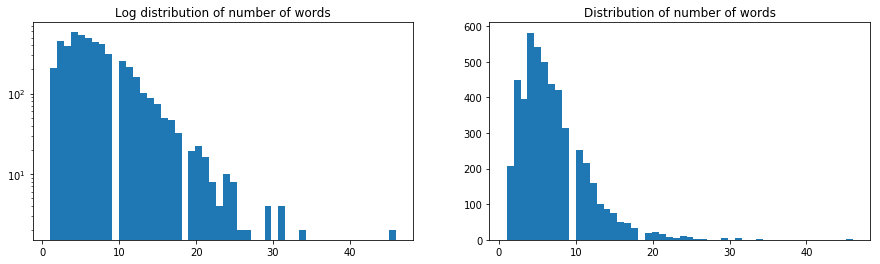

In [182]:
f = plt.figure(figsize=(15, 4))

ax = plt.subplot(1, 2, 1)
ax.set_title('Log distribution of number of words')
n, bins, patches = ax.hist(l, 50, log=True)

ax = plt.subplot(1, 2, 2)
ax.set_title('Distribution of number of words')
n, bins, patches = ax.hist(l, 50)

It seems from thoses distributions that `50` is enough.

# Find nearest neighbours

In [183]:
from sklearn.neighbors import NearestNeighbors

In [184]:
def build_nearest_neighbours(tree, k=2):
    """Build and return scikit NearestNeighbors
    along with neighbours_node_list which will
    later be usefull for checking what node
    was mapped to what.
    
    Inputs:
        - anytree
        - number of nearest neighbours
    """

    # Stack and flatten all embeddings
    # from a given tree
    neighbours_node_list = [node for node in LevelOrderIter(tree) if node.name != 'top']
    embeddings = np.array([node.embedding.flatten() for node in LevelOrderIter(tree) if node.name != 'top'])

    # Initiate scikit learn NearestNeighbors
    neighbours = NearestNeighbors(
        n_neighbors=k,
        algorithm='ball_tree'
    ).fit(embeddings)

    return neighbours, neighbours_node_list

In [185]:
neighbours, neighbours_node_list = build_nearest_neighbours(tree1, k=2)

In [ ]:
def map_entire_tree(tree, neighbours):
    embeddings = np.array([node.embedding.flatten() for node in LevelOrderIter(tree) if node.name != 'top'])

    print('Computing KNN...')
    distances, indices = neighbours.kneighbors(embeddings)

    return distances, indices, embeddings

In [ ]:
%%time
distances, indices, embeddings = map_entire_tree(tree2, neighbours)

Computing KNN...


In [ ]:
print('Percentage of not directly matched: {:.2f} % ({}/{})'.format(
        distances[distances[:,0] != 0].shape[0] / distances.shape[0] * 100,
        distances[distances[:,0] != 0].shape[0],
        distances.shape[0]
    )
)

In [ ]:
f = plt.figure(figsize=(10, 4))

ax = plt.subplot(1, 1, 1)
ax.set_title('Distribution of distances of imperfectly matched nodes')
n, bins, patches = ax.hist(distances[distances[:,0] != 0][:,0], 50)
# n, bins, patches = ax.hist(distances[:,1], 50, alpha=0.5)

## Printing imperfect matches

In [ ]:
def my_pad(a, l):
    """Util function for padding Python arrays."""

    for _ in range(l - len(a)):
        a.append("")
    return a

In [ ]:
nodes = np.array([node for node in LevelOrderIter(tree2) if node.name != 'top'])

for i in range(indices.shape[0]):
    if distances[i,0] != 0:
        print('{};{};{};{};{}'.format(
            ';'.join(my_pad(neighbours_node_list[indices[i, 0]].id, 5)),
            neighbours_node_list[indices[i, 0]].name,
            ';'.join(my_pad(nodes[i].id, 5)),
            nodes[i].name,
            distances[i, 0]
        ))

In [ ]:
for node in neighbours_node_list:
    if '170' in node.id:
        print(node.name)
        print(node.id)

In [ ]:
for node in nodes:
    if '159' in node.id:
        print(node.name)
        print(node.id)